In [1]:
# [기본 세팅] ------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# 윈도우 한글 폰트 + 마이너스 표시 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 표시에 도움되는 옵션 (너무 길게 줄바꿈되는 것 방지)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

print("✅ 기본 세팅 완료")

✅ 기본 세팅 완료


In [2]:
# === [번들에서 복원] ===
import pickle

BUNDLE_PATH = "_snapshots/olist_clean_bundle.pkl"

with open(BUNDLE_PATH, "rb") as f:
    bundle = pickle.load(f)

# 변수로 바로 풀어서 사용
orders_clean       = bundle["orders_clean"]
order_items_clean  = bundle["order_items_clean"]
payments_clean     = bundle["payments_clean"]
reviews_clean      = bundle["reviews_clean"]
customers_clean    = bundle["customers_clean"]
geolocation_clean  = bundle["geolocation_clean"]
products_clean     = bundle["products_clean"]
sellers_clean      = bundle["sellers_clean"]
category_tr_clean  = bundle["category_tr_clean"]
rfm =   bundle["rfm"]

print("✅ Restored all *_clean DataFrames")

✅ Restored all *_clean DataFrames


In [12]:
# === 블럭 1) 카테고리 영문명 보장 ===
# products_clean에 category_en이 없으면 번역 테이블로 매핑
if "category_en" not in products_clean.columns:
    cat_map = (category_tr_clean
               .set_index("product_category_name")["product_category_name_english"]
               .to_dict())
    products_clean = products_clean.copy()
    products_clean["category_en"] = products_clean["product_category_name"].map(cat_map).fillna("unknown")

# 이후 사용할 열만 보관
products_cat = products_clean[["product_id","category_en"]].copy()


In [13]:
# === 블럭 2) 카테고리×월 집계 + 결측월 0 채움 ===
# 1) 배송완료 주문의 구매월
od = orders_clean.loc[orders_clean["order_status"]=="delivered",
                      ["order_id","order_purchase_timestamp"]].dropna()
od["order_month"] = pd.to_datetime(od["order_purchase_timestamp"]).dt.to_period("M").dt.to_timestamp()

# 2) 아이템 + 카테고리 결합
oi = order_items_clean[["order_id","product_id","price"]].copy()
oi = oi.merge(products_cat, on="product_id", how="left")
oi["category_en"] = oi["category_en"].fillna("unknown")

# 3) 주문-아이템 결합 → 월·카테고리 집계
od_oi = od.merge(oi, on="order_id", how="inner")
cat_monthly = (od_oi.groupby(["category_en","order_month"])
                 .agg(sales=("price","sum"),
                      items=("product_id","count"),
                      orders=("order_id","nunique"))
                 .reset_index())

# 4) 카테고리별로 월 결측을 0으로 채워 연속 월 만들기
def _complete_months(df_cat):
    idx = pd.date_range(df_cat["order_month"].min(), df_cat["order_month"].max(), freq="MS")
    out = df_cat.set_index("order_month").reindex(idx)
    out.index.name = "order_month"
    return out.reset_index()

filled = []
for cat, g in cat_monthly.groupby("category_en", sort=False):
    gg = _complete_months(g)
    gg["category_en"] = cat
    for col in ["sales","items","orders"]:
        gg[col] = gg[col].fillna(0.0)
    filled.append(gg)

cat_monthly_full = pd.concat(filled, ignore_index=True)
display(cat_monthly_full.head())


,order_month,category_en,sales,items,orders
0,2017-01-01,agro_industry_and_commerce,65.97,3.0,2.0
1,2017-02-01,agro_industry_and_commerce,224.84,7.0,7.0
2,2017-03-01,agro_industry_and_commerce,81.99,2.0,2.0
3,2017-04-01,agro_industry_and_commerce,0.00,0.0,0.0
4,2017-05-01,agro_industry_and_commerce,1579.94,4.0,4.0


In [14]:
# === 블럭 3) 계절지수(12M) + 지표 + 요약 ===
def seasonal_index_by_moy(series: pd.Series) -> np.ndarray:
    """
    입력: 월별 시계열(series: DatetimeIndex[MS] 권장)
    출력: 길이 12의 계절지수(SI_01..SI_12), 전체 평균 대비 월 평균 비율
    """
    s = series.asfreq("MS", fill_value=0.0)
    moy_mean = s.groupby(s.index.month).mean()          # 1..12월 평균
    overall = moy_mean.mean()
    if overall == 0 or pd.isna(overall):
        return np.ones(12, dtype=float)
    si = (moy_mean / overall).reindex(range(1,13)).fillna(1.0).to_numpy(dtype=float)
    return si if si.size == 12 else np.pad(si, (0, 12-len(si)), constant_values=1.0)

def acf_at_lag(series: pd.Series, lag=12):
    s = series.asfreq("MS", fill_value=0.0).to_numpy(dtype=float)
    if len(s) <= lag or np.allclose(s.std(), 0):
        return np.nan
    s = s - s.mean()
    return float(np.corrcoef(s[lag:], s[:-lag])[0,1])

rows = []
for cat, g in cat_monthly_full.groupby("category_en", sort=False):
    s = g.set_index("order_month")["sales"].asfreq("MS", fill_value=0.0)
    if s.sum()==0 or len(s)<6:   # 너무 짧은 시계열은 제외
        continue
    si_vec = seasonal_index_by_moy(s)
    rows.append({
        "category_en": cat,
        "amp": float(si_vec.max()-si_vec.min()),                 # 계절 진폭
        "cv":  float(s.std()/s.mean()) if s.mean()>0 else np.nan, # 변동계수
        "acf12": acf_at_lag(s, 12),                               # 연간주기성
        "total_sales": float(s.sum()),
        "si_vec": si_vec.tolist()
    })

seasonality = pd.DataFrame(rows)
si_cols = [f"SI_{m:02d}" for m in range(1,13)]
if not seasonality.empty:
    seasonality[si_cols] = pd.DataFrame(seasonality["si_vec"].tolist(), index=seasonality.index)
    seasonality = seasonality.drop(columns=["si_vec"])

# 우선순위 점수(강도/변동성/주기성)
if not seasonality.empty:
    amp_norm = seasonality["amp"] / (seasonality["amp"].max() or 1)
    cv_norm  = seasonality["cv"]  / (seasonality["cv"].max()  or 1)
    acf_pos  = seasonality["acf12"].clip(lower=0)
    acf_norm = acf_pos / (acf_pos.max() or 1)
    summary = (seasonality
               .assign(priority_score = 0.5*amp_norm + 0.3*cv_norm + 0.2*acf_norm)
               .sort_values("priority_score", ascending=False))
else:
    summary = pd.DataFrame(columns=["category_en","amp","cv","acf12","priority_score"])

print("=== [계절성 요약 상위 15] ===")
display(summary[["category_en","amp","cv","acf12","priority_score"]].head(15))

c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


=== [계절성 요약 상위 15] ===


,category_en,amp,cv,acf12,priority_score
3,arts_and_craftmanship,5.913180,2.346521,0.300782,0.860156
46,home_comfort_2,4.955293,1.911616,0.245927,0.712587
2,art,3.924501,1.281999,0.427972,0.581340
34,fixed_telephony,4.598040,1.327212,-0.052828,0.558478
64,small_appliances_home_oven_and_coffee,3.872122,1.356141,-0.509125,0.500795
25,dvds_blu_ray,3.601443,1.505742,-0.198252,0.497034
13,cine_photo,3.585038,1.500260,-0.147683,0.494946
55,music,3.461825,1.519021,-0.237092,0.486926
14,computers,3.650342,1.326105,-0.000602,0.478202
18,construction_tools_lights,1.809054,0.926837,1.000000,0.471463


In [15]:
# === 블럭 4) 상위 카테고리(최근 12M) 선정 ===
cutoff = cat_monthly_full["order_month"].max()
t12 = cutoff - pd.DateOffset(months=12) + pd.offsets.MonthBegin(0)
mask12 = cat_monthly_full["order_month"] >= t12

top_cats = (cat_monthly_full.loc[mask12]
            .groupby("category_en")["sales"].sum()
            .sort_values(ascending=False).head(8).index.tolist())

print("Top 카테고리:", top_cats)

Top 카테고리: ['health_beauty', 'watches_gifts', 'bed_bath_table', 'sports_leisure', 'computers_accessories', 'furniture_decor', 'housewares', 'auto']


In [16]:
# === 블럭 5) 6개월 예측 + forecast_df ===
def forecast_next_6(series: pd.Series) -> pd.Series:
    """
    base = 최근 12M 평균
    g    = (최근12합/그전12합)^(1/12)-1 (가능할 때)
    예측 = base * (1+g)^t * SI(month)
    """
    s = series.asfreq("MS", fill_value=0.0)
    if len(s) < 6:
        return pd.Series(dtype=float)

    end = s.index.max()
    last12  = s.loc[end - pd.DateOffset(months=11): end]
    prev12  = s.loc[end - pd.DateOffset(months=23): end - pd.DateOffset(months=12)]
    base = last12.mean()
    if (len(prev12)==12) and (prev12.sum()>0):
        g = (last12.sum()/prev12.sum())**(1/12) - 1
    else:
        g = 0.0

    si = seasonal_index_by_moy(s)
    future_idx = pd.date_range(end + pd.DateOffset(months=1), periods=6, freq="MS")
    vals = []
    for i, dt in enumerate(future_idx, start=1):
        m = dt.month
        vals.append(base * ((1+g)**i) * float(si[m-1]))
    return pd.Series(vals, index=future_idx)

# 카테고리별 예측 테이블
fc_rows = []
for cat, g in cat_monthly_full.groupby("category_en", sort=False):
    s = g.set_index("order_month")["sales"]
    fc = forecast_next_6(s)
    if fc.empty: 
        continue
    for dt, val in fc.items():
        fc_rows.append({"category_en":cat, "order_month":dt, "forecast_sales":float(val)})
forecast_df = pd.DataFrame(fc_rows)
display(forecast_df.head())

,category_en,order_month,forecast_sales
0,agro_industry_and_commerce,2018-09-01,2764.806571
1,agro_industry_and_commerce,2018-10-01,4645.397498
2,agro_industry_and_commerce,2018-11-01,19318.371655
3,agro_industry_and_commerce,2018-12-01,7337.312087
4,agro_industry_and_commerce,2019-01-01,4103.837948


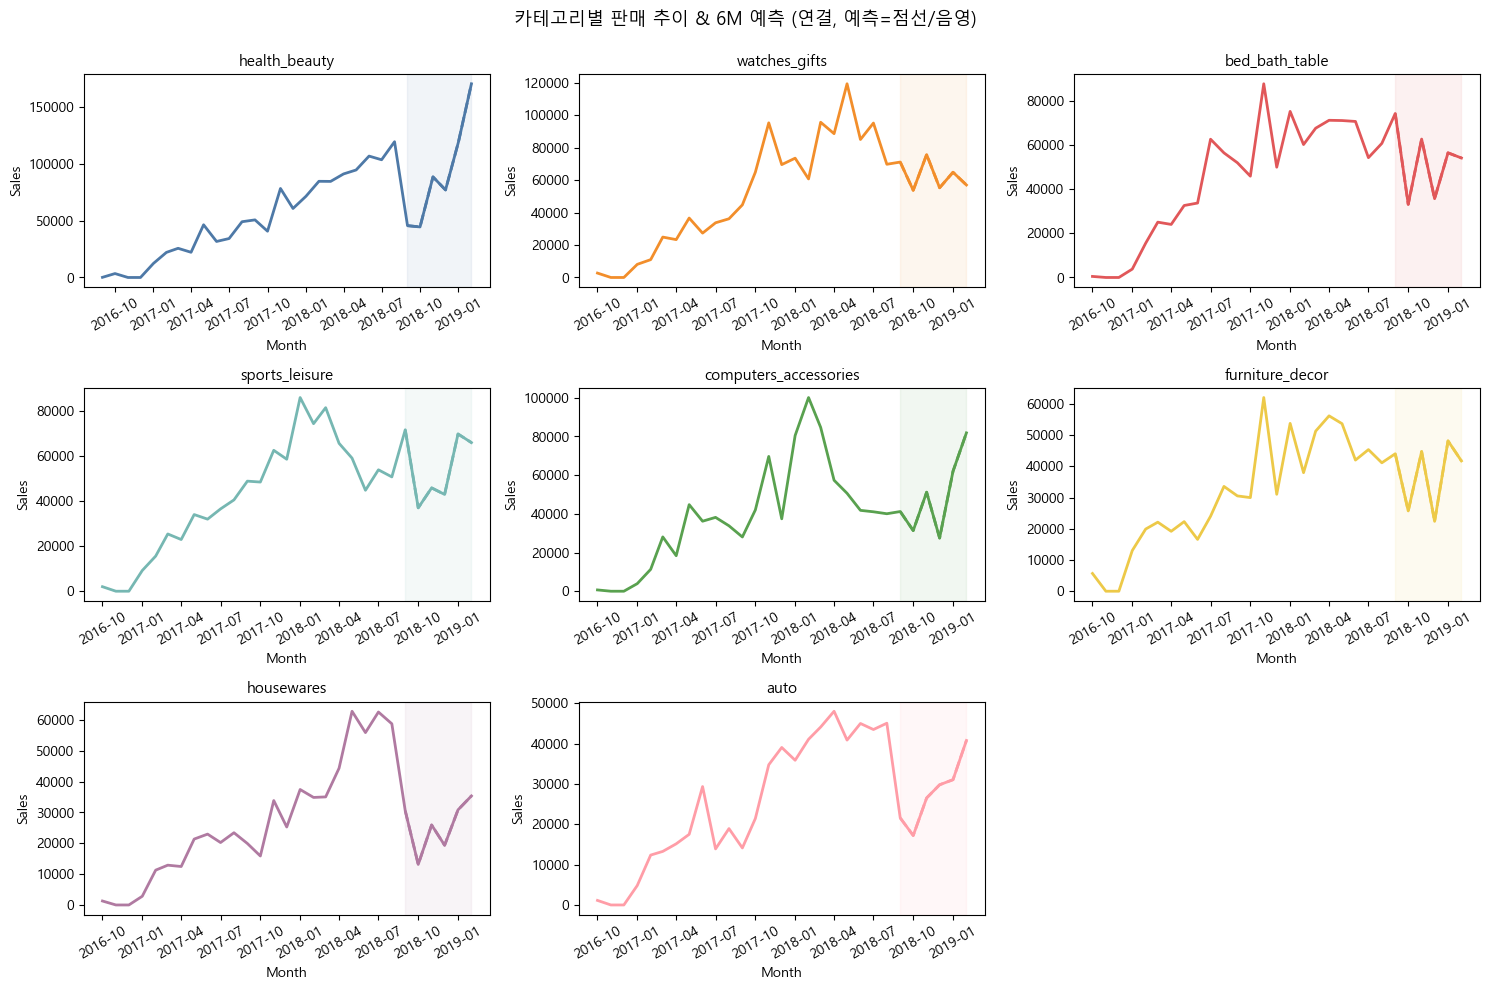

In [18]:
# === 블럭 6) 자연스러운 예측 시각화(서브플롯) ===
# 색상 팔레트
colors = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F",
          "#EDC948","#B07AA1","#FF9DA7","#9C755F","#2E7C9E"]

plot_cats = top_cats
n = len(plot_cats)
if n > 0:
    cols = 3
    rows = (n + cols - 1)//cols
    fig = plt.figure(figsize=(5*cols, 3.3*rows))
    for i, cat in enumerate(plot_cats, start=1):
        ax = fig.add_subplot(rows, cols, i)
        g = cat_monthly_full[cat_monthly_full["category_en"]==cat]
        s = g.set_index("order_month")["sales"].asfreq("MS", fill_value=0.0)

        # 최근 24개월만 깔끔히 보여주기
        start = max(s.index.min(), s.index.max() - pd.DateOffset(months=24) + pd.offsets.MonthBegin(0))
        hist = s.loc[start:]
        fc = forecast_df[forecast_df["category_en"]==cat].set_index("order_month")["forecast_sales"]

        c = colors[(i-1) % len(colors)]
        # 전체 라인(연결)
        if not fc.empty:
            comb = pd.concat([hist, fc])
        else:
            comb = hist.copy()
        ax.plot(comb.index, comb.values, color=c, linewidth=2)

        # 예측 구간 강조: 점선 + 음영
        if not fc.empty:
            ax.plot(fc.index, fc.values, color=c, linewidth=2, linestyle="--", label="Forecast")
            ax.axvspan(fc.index.min(), fc.index.max(), color=c, alpha=0.08)

        ax.set_title(cat, fontsize=11)
        ax.set_xlabel("Month"); ax.set_ylabel("Sales")
        ax.tick_params(axis="x", labelrotation=30)
    fig.suptitle("카테고리별 판매 추이 & 6M 예측 (연결, 예측=점선/음영)", y=0.995, fontsize=13)
    fig.tight_layout()
    plt.show()

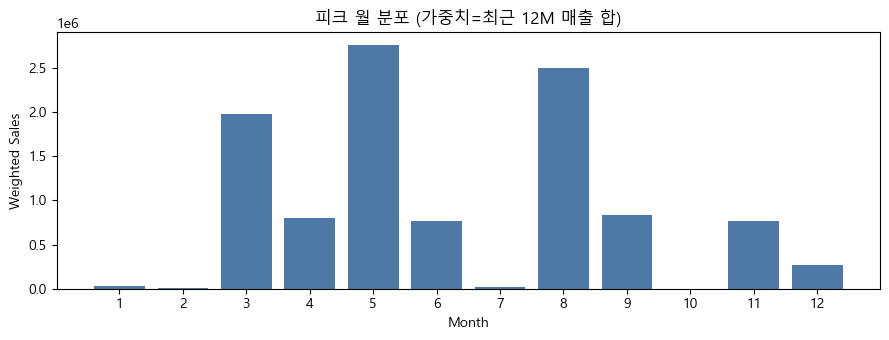

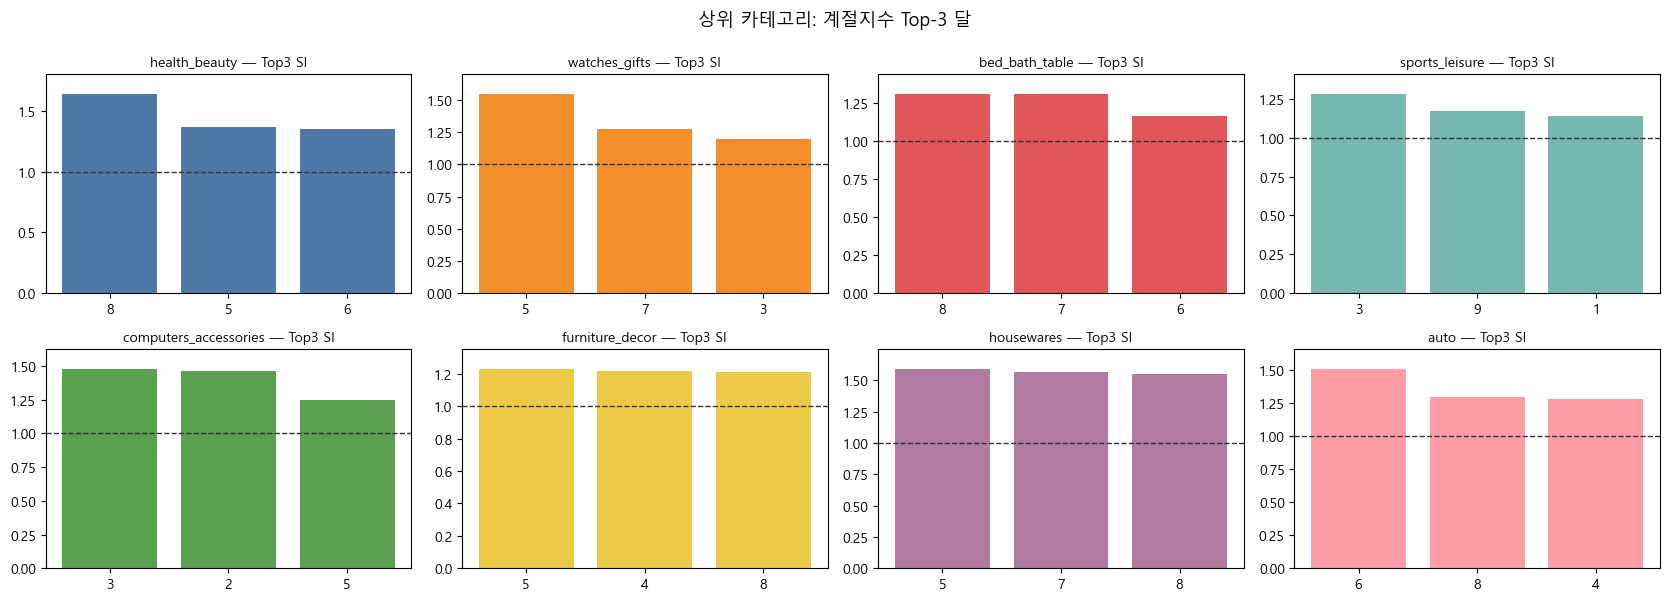

In [19]:
# === 블럭 7A) 피크 월 분포(가중치=최근 12M 매출) ===
if not seasonality.empty:
    si_mat = seasonality.set_index("category_en")[[f"SI_{m:02d}" for m in range(1,13)]].copy()
    # 카테고리별 피크월(1~12)
    peak_month = si_mat.apply(lambda r: int(np.argmax(r.values))+1, axis=1)

    # 최근 12M 매출 가중치
    cutoff = cat_monthly_full["order_month"].max()
    t12 = cutoff - pd.DateOffset(months=12) + pd.offsets.MonthBegin(0)
    w = (cat_monthly_full[cat_monthly_full["order_month"]>=t12]
         .groupby("category_en")["sales"].sum())

    peak_df = (pd.DataFrame({"peak_month": peak_month})
               .merge(w.rename("weight"), left_index=True, right_index=True, how="left")
               .fillna(0))
    weight_by_month = peak_df.groupby("peak_month")["weight"].sum().reindex(range(1,13)).fillna(0)

    plt.figure(figsize=(9,3.5))
    plt.bar(range(1,13), weight_by_month.values, color=colors[0])
    plt.title("피크 월 분포 (가중치=최근 12M 매출 합)")
    plt.xlabel("Month"); plt.ylabel("Weighted Sales")
    plt.xticks(range(1,13))
    plt.tight_layout(); plt.show()

# === 블럭 7B) 상위 카테고리 Top-3 시즌 달 미니 바차트 ===
if not seasonality.empty and len(top_cats) > 0:
    cols = 4
    rows = (len(top_cats) + cols - 1)//cols
    fig = plt.figure(figsize=(4.2*cols, 3*rows))
    for i, cat in enumerate(top_cats, start=1):
        ax = fig.add_subplot(rows, cols, i)
        row = seasonality.loc[seasonality["category_en"]==cat]
        if row.empty:
            ax.set_axis_off(); continue
        si_vals = row[[f"SI_{m:02d}" for m in range(1,13)]].iloc[0].values
        top3_idx = np.argsort(si_vals)[-3:][::-1]  # 상위 3개월
        months = [str(int(m+1)) for m in top3_idx]
        vals = si_vals[top3_idx]
        ax.bar(months, vals, color=colors[(i-1)%len(colors)])
        ax.axhline(1.0, linestyle="--", color="#333333", linewidth=1)
        ax.set_title(f"{cat} — Top3 SI", fontsize=10)
        ax.set_ylim(0, max(1.2, float(vals.max())*1.1))
    fig.suptitle("상위 카테고리: 계절지수 Top-3 달", y=0.995, fontsize=13)
    fig.tight_layout()
    plt.show()


In [ ]:
# === 블럭 8) 재고전략 표 (안전재고 & ROP) ===
# 파라미터: 서비스레벨 95% → z=1.65 (원하면 조정)
# 서비스레벨 z(예: 95% → 1.65) 올리면 안전재고가 커지고, 품절 위험은 줄지만 보관비 증가함.
z = 1.65

# 1) 카테고리별 평균 리드타임(일) 추정: 주문→배송 소요
o = orders_clean.loc[orders_clean["order_status"]=="delivered",
                     ["order_id","order_purchase_timestamp","order_delivered_customer_date"]].dropna()
o["lead_days"] = (o["order_delivered_customer_date"] - o["order_purchase_timestamp"]).dt.total_seconds()/86400

oi = order_items_clean[["order_id","product_id"]].copy()
oi = oi.merge(products_cat, on="product_id", how="left").dropna(subset=["category_en"])
oi_o = oi.merge(o[["order_id","lead_days"]], on="order_id", how="inner")
lt_by_cat = oi_o.groupby("category_en")["lead_days"].mean().rename("lead_days_mean")

# 2) 최근 12M 월 수요 통계(평균/표준편차)
cutoff = cat_monthly_full["order_month"].max()
t12 = cutoff - pd.DateOffset(months=12) + pd.offsets.MonthBegin(0)
last12 = (cat_monthly_full[cat_monthly_full["order_month"]>=t12]
          .groupby(["category_en","order_month"])["sales"].sum()
          .reset_index())

mu_sigma = (last12.groupby("category_en")["sales"]
                 .agg(mu_month="mean", sigma_month="std")
                 .fillna(0.0))

# 3) 월→일 근사 변환 + 안전재고/ROP 계산
inv = (mu_sigma.merge(lt_by_cat, left_index=True, right_index=True, how="left")
               .fillna({"lead_days_mean": 7.0}))  # 리드타임 없으면 7일 가정(보수적)

inv["mu_daily"]    = inv["mu_month"]   / 30.0
inv["sigma_daily"] = inv["sigma_month"] / np.sqrt(30.0)

# 안전재고 = z * σ_daily * sqrt(LT)
# ROP      = μ_daily * LT + 안전재고
inv["safety_stock"] = (z * inv["sigma_daily"] * np.sqrt(inv["lead_days_mean"])).clip(lower=0)
inv["ROP"]          = (inv["mu_daily"] * inv["lead_days_mean"] + inv["safety_stock"]).clip(lower=0)

# 보기 좋게 컬럼 정리
inv_out = inv.reset_index().rename(columns={
    "category_en":"카테고리",
    "mu_month":"월평균수요",
    "sigma_month":"월표준편차",
    "lead_days_mean":"평균리드타임(일)",
    "mu_daily":"일평균수요",
    "sigma_daily":"일표준편차",
    "safety_stock":"안전재고",
    "ROP":"재주문점(ROP)"
})
num_cols = ["월평균수요","월표준편차","일평균수요","일표준편차","안전재고","재주문점(ROP)"]
inv_out[num_cols] = inv_out[num_cols].round(2)
inv_out["평균리드타임(일)"] = inv_out["평균리드타임(일)"].round(1)

# 관리 우선: 상위 카테고리
focus = inv_out[inv_out["카테고리"].isin(top_cats)].copy()
focus = focus.sort_values("재주문점(ROP)", ascending=False)

print(f"=== 재고전략 표(상위 카테고리 우선) — z={z} 기준 ===")
display(focus[["카테고리","월평균수요","월표준편차","평균리드타임(일)","안전재고","재주문점(ROP)"]])

print("✅ 예측 서브플롯 + 시즌 대체 시각화 + 재고전략 표")


=== 재고전략 표(상위 카테고리 우선) — z=1.65 기준 ===


,카테고리,월평균수요,월표준편차,평균리드타임(일),안전재고,재주문점(ROP)
43,health_beauty,79620.46,24166.20,12.0,25196.69,56989.34
71,watches_gifts,76807.62,22813.56,12.7,24456.14,56877.09
15,computers_accessories,54403.91,22453.23,13.2,24598.29,48581.90
7,bed_bath_table,63468.58,11895.19,12.8,12823.58,39917.19
65,sports_leisure,59749.30,14089.76,12.1,14794.56,38991.59
49,housewares,39248.84,16375.31,10.9,16303.28,30593.20
39,furniture_decor,43767.27,10883.04,12.9,11766.18,30557.30
5,auto,36270.27,11061.25,12.2,11651.23,26432.71


✅ 예측 서브플롯 + 시즌 대체 시각화 + 재고전략 표
